In [43]:
import os
import numpy as np
import math
import cv2
import glob
from  matplotlib import pyplot as plt
%matplotlib inline
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
print(tf.__version__)
'''
https://www.tensorflow.org/tutorials/load_data/images
從磁碟機讀取 image dataset方法
'''
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import optimizers

2.3.1


In [44]:
# dataset
validation_dir=r'C:\Users\user\chou_paper_data\flower_data\valid'  # testing data
train_dir=r'C:\Users\user\chou_paper_data\flower_data\train'  # training data
test_dir=r'C:\Users\user\chou_paper_data\flower_data\test'  # test data
batch_size=32
img_size=(224, 224)
freeze_layers_number=0
classes=sorted([o for o in os.listdir(train_dir)])  # 根据文件名分类

import requests
import json
file_location=r'C:\Users\user\chou_paper_data\flower_data\cat_to_name.json'
f=open(file_location)
class_names=json.loads(f.read())
class_names = {int(k):v for k,v in class_names.items()}

nb_train_samples = len(glob.glob(train_dir + '/*/*.*'))  # number of training data
nb_validation_samples = len(glob.glob(validation_dir + '/*/*.*'))  # number of validing data
nb_test_samples = len(glob.glob(test_dir + '/*.*'))  # number of test data
print(nb_train_samples,nb_validation_samples,nb_test_samples,'total=',nb_train_samples+nb_validation_samples+nb_test_samples)
'''
data set:
    Oxfordflower-102 public data set, which comes from the flower image database created by the Oxford University Visual Geometry Group.

    https://www.robots.ox.ac.uk/~vgg/data/flowers/102/
'''

6552 818 819 total= 8189


'\ndata set:\n    Oxfordflower-102 public data set, which comes from the flower image database created by the Oxford University Visual Geometry Group.\n\n    https://www.robots.ox.ac.uk/~vgg/data/flowers/102/\n'

In [45]:
def saliency_map(inputdata):
    fft = np.fft.fft2(inputdata)
    fshift = np.fft.fftshift(fft)
    LogAmp = np.log(np.abs(fshift))
    phase =np.angle(fshift)
    #SR
    BlurAmp = cv2.blur(LogAmp, (3,3))
    Spectral_res = LogAmp - BlurAmp
    #saliency map
    ishift = np.fft.ifftshift(np.exp(Spectral_res+1j*phase))
    Res_ifft = np.fft.ifft2(ishift)
    Res = np.abs(Res_ifft)
    #gaussian
    saliency_map = cv2.GaussianBlur(Res, (3,3),8)
    '''
    在Saliency Detection：A Spectral Residual Approach提到,
    用 gaussian fliter g(x)(sigma=8) 不確定是甚麼意思
    '''
    rge=np.max(saliency_map)-np.min(saliency_map)
    norm=(saliency_map-np.min(saliency_map))*255/rge
    return norm
def preprocessing(inputdata):
    inputdata=cv2.cvtColor(inputdata,cv2.COLOR_BGR2GRAY)
    inputdata=saliency_map(inputdata)
    inputdata=np.stack((inputdata,)*3, axis=-1)
    outputdata=cv2.normalize(inputdata.astype('float'), None, 0.0, 1.0, cv2.NORM_MINMAX)
    return outputdata.astype(np.float64)

In [4]:
train_datagen = ImageDataGenerator(
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2,
    preprocessing_function = preprocessing) # set validation split

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    train_dir, # same directory as training data
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation') # set as validation data
'''
ref:Keras split train test set when using ImageDataGenerator
https://stackoverflow.com/questions/42443936/keras-split-train-test-set-when-using-imagedatagenerator

ref:Image data preprocessing
https://keras.io/api/preprocessing/image/
'''

Found 5283 images belonging to 102 classes.
Found 1269 images belonging to 102 classes.


'\nref:Keras split train test set when using ImageDataGenerator\nhttps://stackoverflow.com/questions/42443936/keras-split-train-test-set-when-using-imagedatagenerator\n\nref:Image data preprocessing\nhttps://keras.io/api/preprocessing/image/\n'

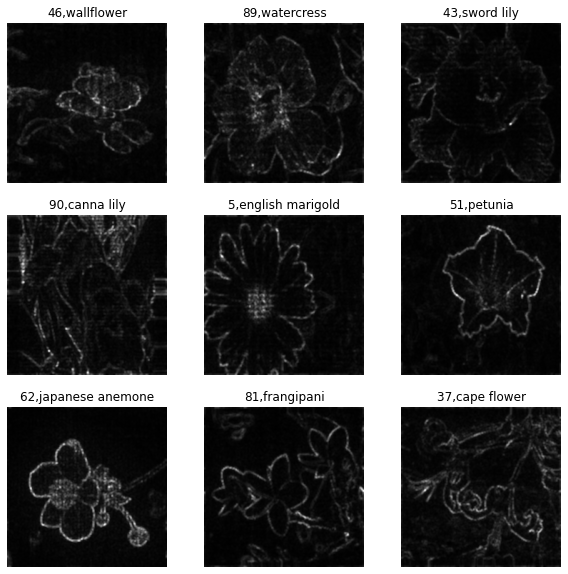

In [5]:
from scipy import ndimage
import scipy.interpolate
datas,labels = train_generator.next()
true_labels=[np.argmax(labels)for labels in labels]
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.title(classes[true_labels[i]]+','+class_names[int(classes[true_labels[i]])])
    plt.axis("off")
    plt.imshow(datas[i])
    plt.title(classes[true_labels[i]]+','+class_names[int(classes[true_labels[i]])])
    plt.axis("off")

In [8]:
base_model=VGG16(weights='imagenet',include_top=False,input_tensor=Input(shape=(224,224,3)))

head_model = base_model.output
head_model = Flatten(name="flatten")(head_model)
head_model = Dense(4096,activation="relu",name='fc6')(head_model)
head_model = Dropout(0.5)(head_model)
head_model = Dense(4096,activation='relu',name='fc7')(head_model)
head_model = Dropout(0.5)(head_model)
head_model = Dense(4000,activation='relu',name='fc8')(head_model)
head_model = Dense(102, activation="softmax",name='softmax')(head_model)
model=Model(base_model.input,head_model)

for layer in base_model.layers:
    layer.trainable=True #目前採用 fine tune做法, 不凍結卷積層權重, 跟後面的 fc層一起訓練
model.summary()

'''
這邊參考完 A Survey on Transfer Learning, Dropout: A Simple Way to Prevent Neural Networks from Overfitting
兩篇後做一點修改, paper上繪製的 model需要確定一下
dropout layer (只知道是放在fully connected layer後), transfer方法還需要確定(這邊不知道適用大資料集,不相似資料的 fine tune)
'''

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

'\n這邊參考完 A Survey on Transfer Learning, Dropout: A Simple Way to Prevent Neural Networks from Overfitting\n兩篇後做一點修改, paper上繪製的 model需要確定一下\ndropout layer (只知道是放在fully connected layer後), transfer方法還需要確定(這邊不知道適用大資料集,不相似資料的 fine tune)\n'

In [9]:
num_epoch=100

optimizer=tf.keras.optimizers.SGD(learning_rate=1e-3, momentum=0.3, nesterov=True, name='SGD')

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
early_stopping = EarlyStopping(verbose=1, patience=10, min_delta=1e-4, monitor='val_accuracy')
callbacks = [early_stopping]

history=model.fit(train_generator,
                  steps_per_epoch=None,
                  validation_data=validation_generator,
                  validation_steps=None,
                  epochs=num_epoch,
                  callbacks=callbacks)

print('Training is finished!')

Epoch 1/100
166/166 [==============================] - 215s 1s/step - loss: 4.6171 - accuracy: 0.0246 - val_loss: 4.5005 - val_accuracy: 0.0323
Epoch 2/100
166/166 [==============================] - 212s 1s/step - loss: 4.5256 - accuracy: 0.0326 - val_loss: 4.4719 - val_accuracy: 0.0426
Epoch 3/100
166/166 [==============================] - 212s 1s/step - loss: 4.4732 - accuracy: 0.0403 - val_loss: 4.3876 - val_accuracy: 0.0638
Epoch 4/100
166/166 [==============================] - 216s 1s/step - loss: 4.4122 - accuracy: 0.0538 - val_loss: 4.2678 - val_accuracy: 0.0638
Epoch 5/100
166/166 [==============================] - 202s 1s/step - loss: 4.3624 - accuracy: 0.0647 - val_loss: 4.2066 - val_accuracy: 0.0678
Epoch 6/100
166/166 [==============================] - 195s 1s/step - loss: 4.2917 - accuracy: 0.0717 - val_loss: 4.1429 - val_accuracy: 0.0757
Epoch 7/100
166/166 [==============================] - 213s 1s/step - loss: 4.2220 - accuracy: 0.0786 - val_loss: 4.1364 - val_accuracy:

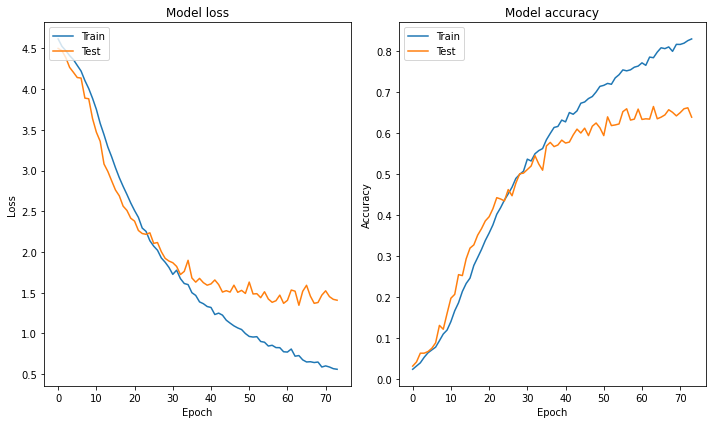

In [10]:
fig, (ax1, ax2) = plt.subplots(figsize=(10,6), ncols=2)
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss']) 
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')
ax1.legend(['Train', 'Test'], loc='upper left')
ax1.set_title(f'Model loss')
ax2.plot(history.history['accuracy'])
ax2.plot(history.history['val_accuracy'])
ax2.set_ylabel('Accuracy')
ax2.set_xlabel('Epoch')
ax2.legend(['Train', 'Test'], loc='upper left')
ax2.set_title(f'Model accuracy')
plt.tight_layout()
plt.savefig(r'C:\Users\user\fc_saliency_vgg16_hitroy.jpg')

In [1]:
'''
model.save('fc_saliency_vgg16.h5')
'''
from tensorflow.keras.models import load_model
model = load_model(r'C:\Users\user\Desktop\問號問號\fc_saliency_vgg16_lr33.h5')

2:99.95%
48:0.05%
62:0.00%
69:0.00%
83:0.00%


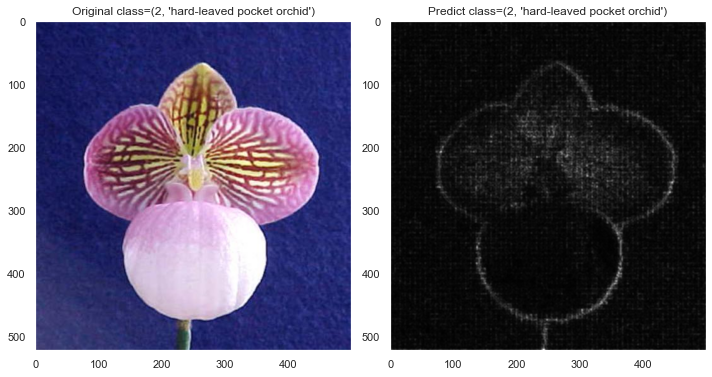

In [56]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
file_path=r'C:\Users\user\chou_paper_data\flower_data\valid'
label_path=r'2'
image_path=r'image_05094.jpg'
orig_image = cv2.imread(file_path+'\\'+label_path+'\\'+image_path)
test_image=preprocessing(orig_image)
pred_image=cv2.resize(test_image,(224,224))

pred_image = pred_image[None]
y = model.predict(pred_image)

for i in np.argsort(y[0])[::-1][:5]:
    print('{}:{:.2f}%'.format(classes[i], y[0][i] * 100))

predict_label=classes[np.argsort(y[0])[::-1][0]]

fig, (ax1, ax2) = plt.subplots(figsize=(10,10), ncols=2)
ax1.imshow(orig_image[:, :, [2, 1, 0]])
ax1.grid(False)
ax1.set_title(f'Original class={int(label_path),class_names[int(label_path)]}')
ax2.imshow(test_image[:, :, [2, 1, 0]])
ax2.grid(False)
ax2.set_title(f'Predict class={int(predict_label),class_names[int(predict_label)]}')
plt.tight_layout()
filename=image_path
#plt.savefig(r'C:\Users\User\Downloads'+'\\'+filename)
plt.show()

In [62]:
import time
start=time.time()
num=0
acc=0
y_true_02=[]
y_pred_02=[]
y_true_25=[]
y_pred_25=[]
y_true_58=[]
y_pred_58=[]
y_true_80=[]
y_pred_80=[]
for root, dirs, files in os.walk(r'C:\Users\user\chou_paper_data\flower_data\valid',topdown=False):
    num_label=0.0
    acc_label=0.0
    y_true_buffer=[]
    y_pred_buffer=[]
    for name in files:
        orig_image=cv2.imread(os.path.join(root,name))
        test_image=preprocessing(orig_image)
        pred_image=cv2.resize(test_image,img_size)
        pred_image=pred_image[None]
        
        y=model.predict(pred_image)
        predict_label=classes[np.argsort(y[0])[::-1][0]]

        file=os.path.basename(os.path.dirname(os.path.dirname(root)))
        #print('file')
        subfile_l1=os.path.basename(os.path.dirname(root))
        #print('sub',subfile_l1) #train, test, validation
        subfile_l2=os.path.basename(root)
        #print('sub',subfile_l2) #label
        
        fig, (ax1, ax2) = plt.subplots(figsize=(10,10), ncols=2)
        ax1.imshow(orig_image[:, :, [2, 1, 0]])
        ax1.grid(False)
        ax1.set_title(f'Original class={int(subfile_l2),class_names[int(subfile_l2)]}')
        ax2.imshow(test_image[:, :, [2, 1, 0]])
        ax2.grid(False)
        ax2.set_title(f'Predict class={int(predict_label),class_names[int(predict_label)]}')
        plt.tight_layout()
        
        write_path=os.path.abspath(os.path.join(root, "../.."))+'_predict fc_saliency_vgg16'

        if subfile_l2==predict_label:
            if os.path.exists(write_path)==False:
                os.mkdir(write_path)
            if os.path.exists(write_path+'\\'+subfile_l1+'_true')==False:
                os.mkdir(write_path+'\\'+subfile_l1+'_true')
            if os.path.exists(write_path+'\\'+subfile_l1+'_true'+'\\'+subfile_l2)==False:
                os.mkdir(write_path+'\\'+subfile_l1+'_true'+'\\'+subfile_l2)

            plt.savefig(write_path+'\\'+subfile_l1+'_true'+'\\'+subfile_l2+'\\'+name)
            acc+=1
            acc_label+=1
        if subfile_l2!=predict_label:
            if os.path.exists(write_path)==False:
                os.mkdir(write_path)
            if os.path.exists(write_path+'\\'+subfile_l1+'_false')==False:
                os.mkdir(write_path+'\\'+subfile_l1+'_false')
            if os.path.exists(write_path+'\\'+subfile_l1+'_false'+'\\'+subfile_l2)==False:
                os.mkdir(write_path+'\\'+subfile_l1+'_false'+'\\'+subfile_l2)
            
            plt.savefig(write_path+'\\'+subfile_l1+'_false'+'\\'+subfile_l2+'\\'+name)
        plt.close()
        num+=1
        num_label+=1
        y_true_buffer.append(subfile_l2)
        y_pred_buffer.append(predict_label)
    if acc_label<=num_label*0.2:
        y_true_02.extend(y_true_buffer)
        y_pred_02.extend(y_pred_buffer)
    if (acc_label<=num_label*0.5) & (acc_label>num_label*0.2):
        y_true_25.extend(y_true_buffer)
        y_pred_25.extend(y_pred_buffer)
    if (acc_label<=num_label*0.8) & (acc_label>num_label*0.5):
        y_true_58.extend(y_true_buffer)
        y_pred_58.extend(y_pred_buffer)
    if acc_label>num_label*0.8:
        y_true_80.extend(y_true_buffer)
        y_pred_80.extend(y_pred_buffer)
end=time.time()
print('accuracy=',acc/num)
print(end-start)

accuracy= 0.5916870415647921
565.8455607891083


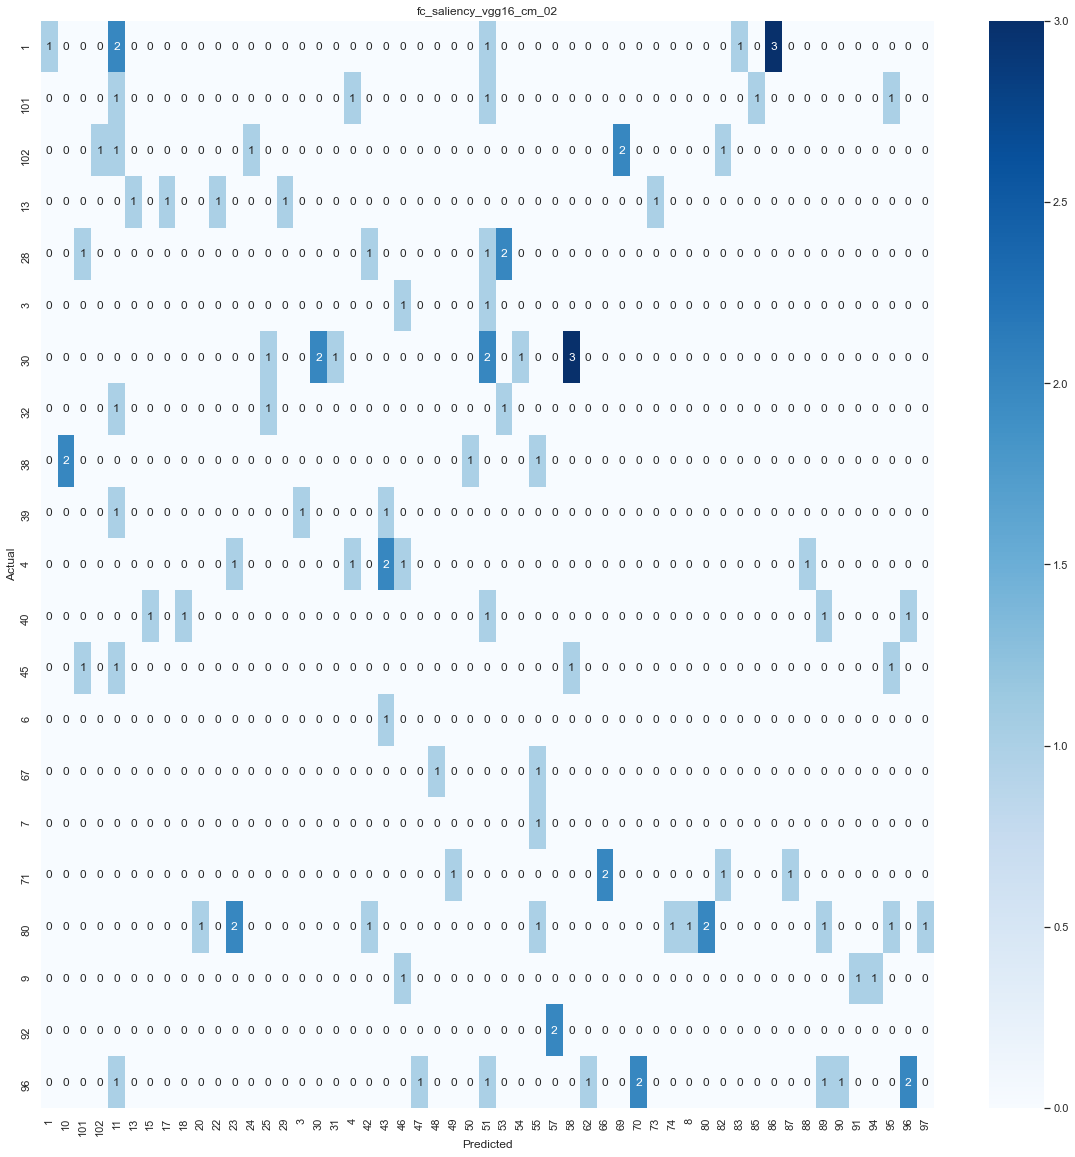

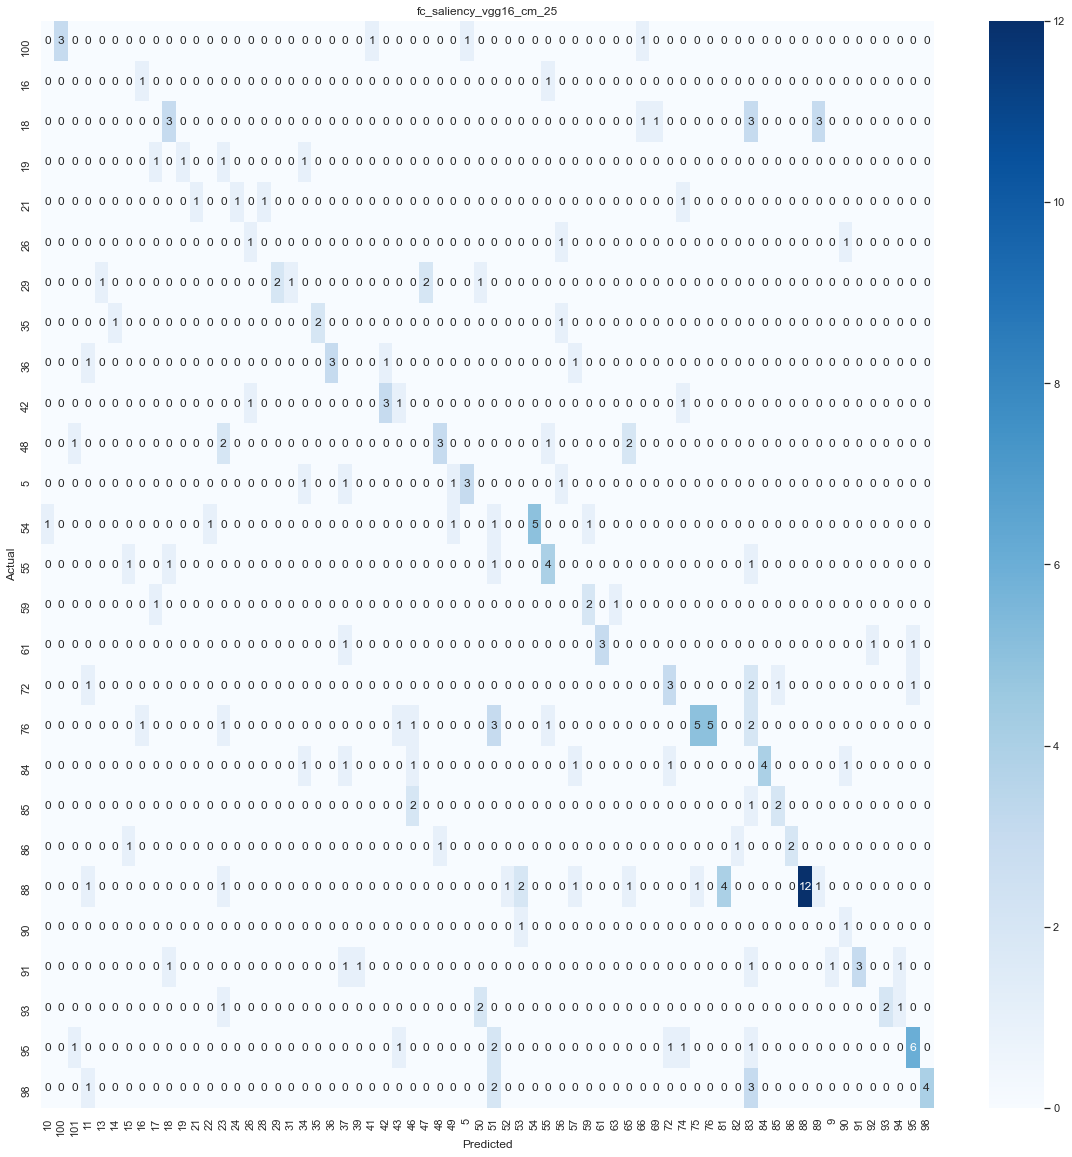

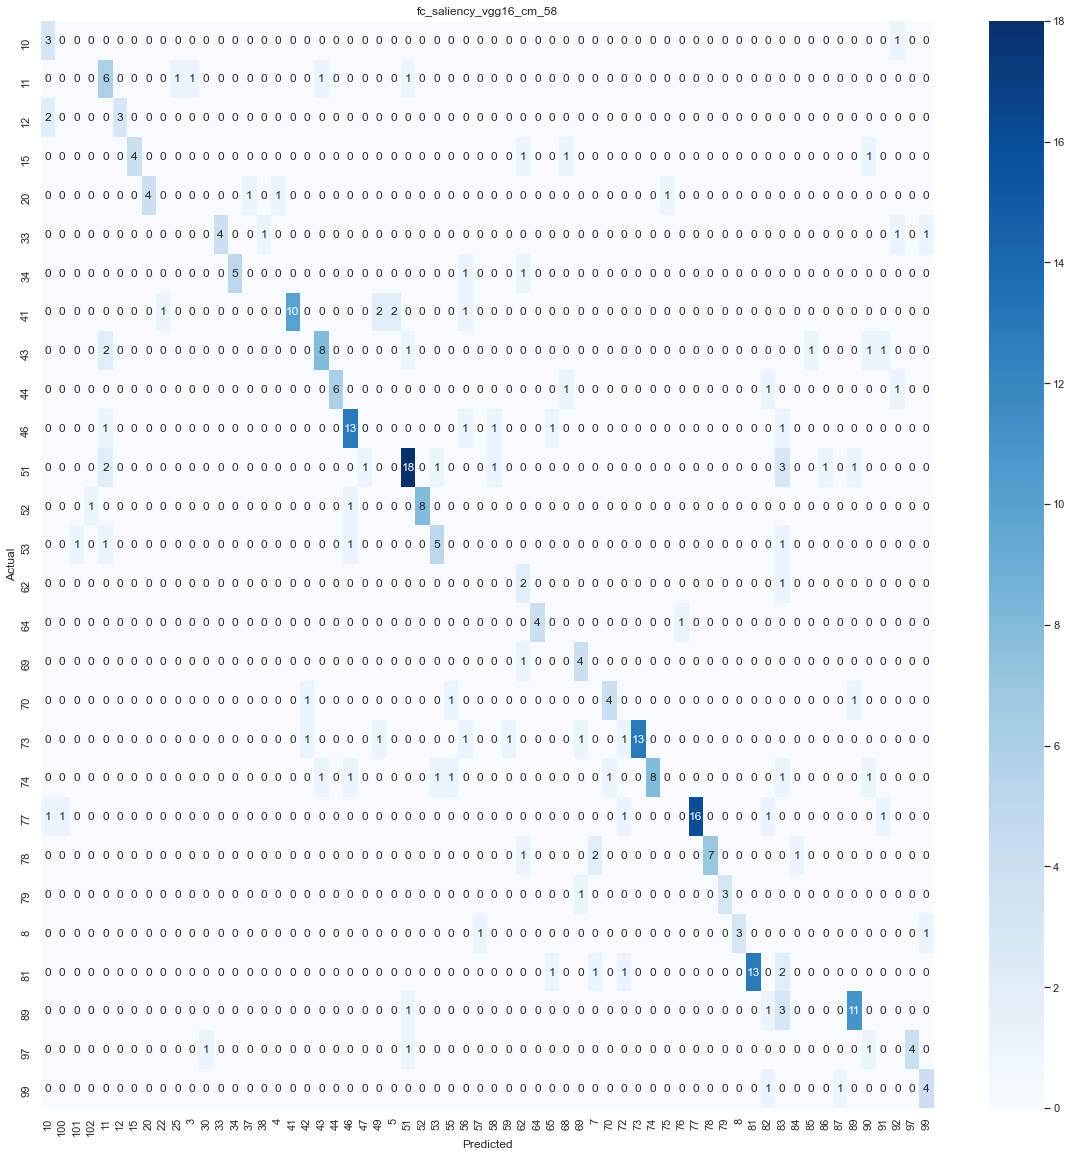

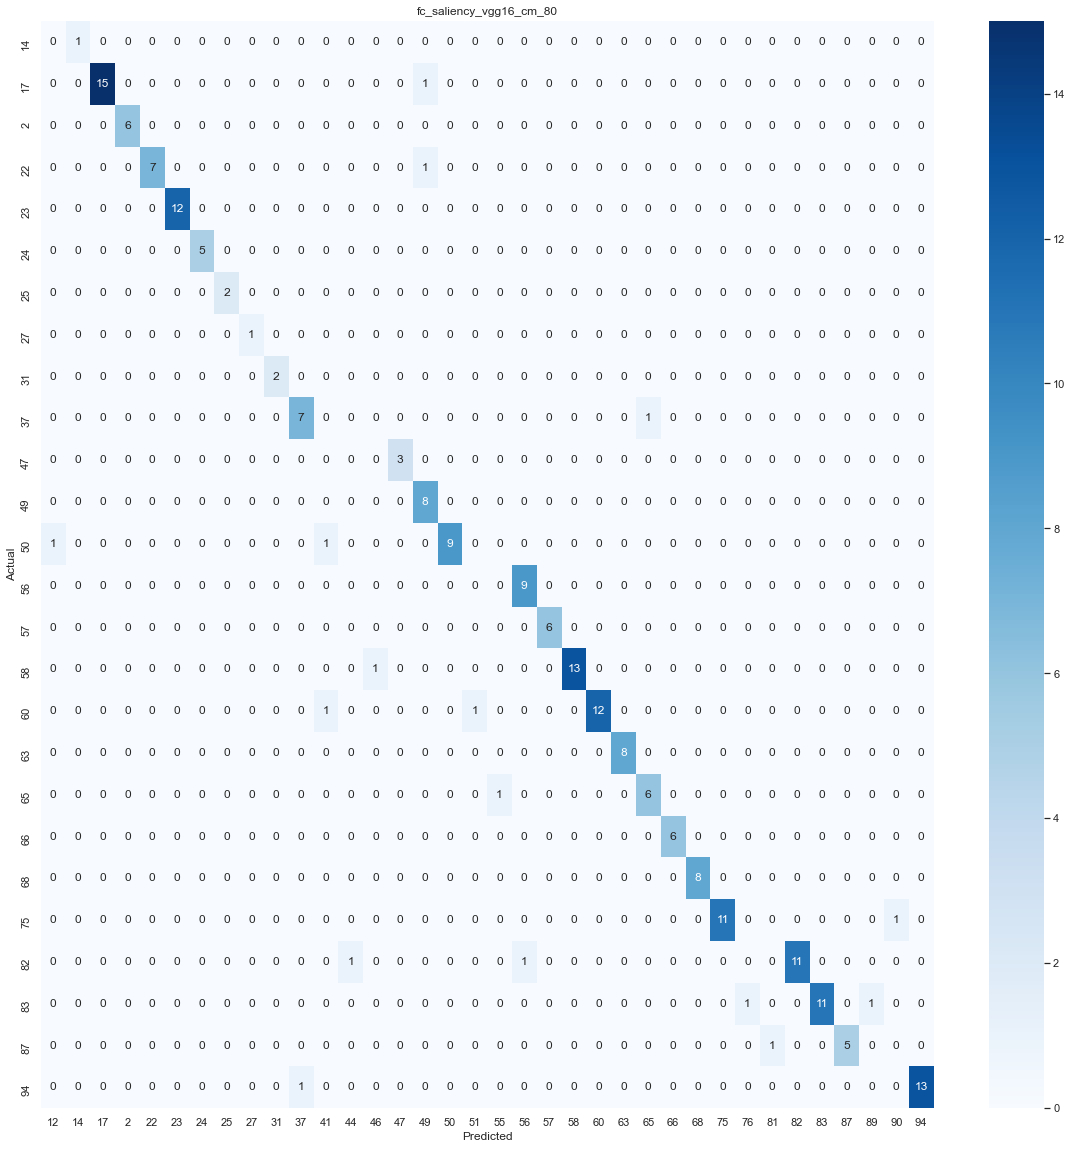

In [63]:
'''
https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea
'''
import pandas as pd
import seaborn as sns
cf_matrix=pd.crosstab([y_true_02], [y_pred_02],rownames=['Actual'], colnames=['Predicted'])
sns.set(rc={'figure.figsize':(20,20)})
sns_plot=sns.heatmap(cf_matrix,annot=True,cmap='Blues')
plt.title('fc_saliency_vgg16_cm_02')
plt.show()
fig=sns_plot.get_figure()
fig.savefig(r'C:\Users\user\Downloads\fc_saliency_vgg16_cm_02.jpg')

cf_matrix=pd.crosstab([y_true_25], [y_pred_25],rownames=['Actual'], colnames=['Predicted'])
sns.set(rc={'figure.figsize':(20,20)})
sns_plot=sns.heatmap(cf_matrix,annot=True,cmap='Blues')
plt.title('fc_saliency_vgg16_cm_25')
plt.show()
fig=sns_plot.get_figure()
fig.savefig(r'C:\Users\user\Downloads\fc_saliency_vgg16_cm_25.jpg')

cf_matrix=pd.crosstab([y_true_58], [y_pred_58],rownames=['Actual'], colnames=['Predicted'])
sns.set(rc={'figure.figsize':(20,20)})
sns_plot=sns.heatmap(cf_matrix,annot=True,cmap='Blues')
plt.title('fc_saliency_vgg16_cm_58')
plt.show()
fig=sns_plot.get_figure()
fig.savefig(r'C:\Users\user\Downloads\fc_saliency_vgg16_cm_58.jpg')

cf_matrix=pd.crosstab([y_true_80], [y_pred_80],rownames=['Actual'], colnames=['Predicted'])
sns.set(rc={'figure.figsize':(20,20)})
sns_plot=sns.heatmap(cf_matrix,annot=True,cmap='Blues')
plt.title('fc_saliency_vgg16_cm_80')
plt.show()
fig=sns_plot.get_figure()
fig.savefig(r'C:\Users\user\Downloads\fc_saliency_vgg16_cm_80.jpg')

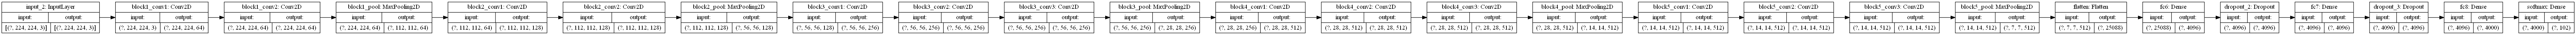

In [64]:
dot_img_file = r'C:\Users\user\Downloads\model_1.png'
tf.keras.utils.plot_model(model,to_file=dot_img_file,show_shapes=True,rankdir='LR')